## tensorflow

In [70]:
import tensorflow as tf
from tensorflow import sin, cos, sqrt

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle

from sionna import SPEED_OF_LIGHT, PI
from sionna.utils import log10


class AntennaElement:
    """Antenna element following the [TR38901]_ specification

    Parameters
    ----------

    pattern : str
        Radiation pattern. Should be "omni" or "38.901".

    slant_angle : float
        Polarization slant angle [radian]

    dtype : tf.DType
        Complex datatype to use for internal processing and output.
        Defaults to `tf.complex64`.
    """

    def __init__(self,
                 pattern,
                 slant_angle=0.0,
                 dtype=tf.complex64,
                ):

        assert pattern in ["omni", "38.901"], \
            "The radiation_pattern must be one of [\"omni\", \"38.901\"]."
        assert dtype.is_complex, "'dtype' must be complex type"

        self._pattern = pattern
        self._slant_angle = tf.constant(slant_angle, dtype=dtype.real_dtype)

        # Selected the radiation field correspding to the requested pattern
        if pattern == "omni":
            self._radiation_pattern = self._radiation_pattern_omni
        else:
            self._radiation_pattern = self._radiation_pattern_38901

        self._dtype = dtype

    def field(self, theta, phi):
        """
        Field pattern in the vertical and horizontal polarization (7.3-4/5)

        Inputs
        -------
        theta:
            Zenith angle wrapped within (0,pi) [radian]

        phi:
            Azimuth angle wrapped within (-pi, pi) [radian]
        """
        a = sqrt(self._radiation_pattern(theta, phi))
        f_theta = a * cos(self._slant_angle)
        f_phi   = a * sin(self._slant_angle)
        return (f_theta, f_phi)

    def show(self):
        """
        Shows the field pattern of an antenna element
        """
        theta = tf.linspace(0.0, PI, 361)
        phi = tf.linspace(-PI, PI, 361)
        a_v = 10*log10(self._radiation_pattern(theta, tf.zeros_like(theta) ))
        a_h = 10*log10(self._radiation_pattern(PI/2*tf.ones_like(phi) , phi))

        fig = plt.figure()
        plt.polar(theta, a_v)
        fig.axes[0].set_theta_zero_location("N")
        fig.axes[0].set_theta_direction(-1)
        plt.title(r"Vertical cut of the radiation pattern ($\phi = 0 $) ")
        plt.legend([f"{self._pattern}"])

        fig = plt.figure()
        plt.polar(phi, a_h)
        fig.axes[0].set_theta_zero_location("E")
        plt.title(r"Horizontal cut of the radiation pattern ($\theta = \pi/2$)")
        plt.legend([f"{self._pattern}"])

        theta = tf.linspace(0.0, PI, 50)
        phi = tf.linspace(-PI, PI, 50)
        phi_grid, theta_grid = tf.meshgrid(phi, theta)
        a = self._radiation_pattern(theta_grid, phi_grid)
        x = a * sin(theta_grid) * cos(phi_grid)
        y = a * sin(theta_grid) * sin(phi_grid)
        z = a * cos(theta_grid)
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.plot_surface(x, y, z, rstride=1, cstride=1,
                        linewidth=0, antialiased=False, alpha=0.5)
        ax.view_init(elev=30., azim=-45)
        plt.xlabel("x")
        plt.ylabel("y")
        ax.set_zlabel("z")
        plt.title(f"Radiation power pattern ({self._pattern})")


    ###############################
    # Utility functions
    ###############################

    # pylint: disable=unused-argument
    def _radiation_pattern_omni(self, theta, phi):
        """
        Radiation pattern of an omnidirectional 3D radiation pattern

        Inputs
        -------
        theta:
            Zenith angle

        phi:
            Azimuth angle
        """
        return tf.ones_like(theta)

    def _radiation_pattern_38901(self, theta, phi):
        """
        Radiation pattern from TR38901 (Table 7.3-1)

        Inputs
        -------
        theta:
            Zenith angle wrapped within (0,pi) [radian]

        phi:
            Azimuth angle wrapped within (-pi, pi) [radian]
        """
        theta_3db = phi_3db = 65/180*PI
        a_max = sla_v = 30
        g_e_max = 8
        a_v = -tf.minimum(12*((theta-PI/2)/theta_3db)**2, sla_v)
        a_h = -tf.minimum(12*(phi/phi_3db)**2, a_max)
        a_db = -tf.minimum(-(a_v + a_h), a_max) + g_e_max
        return 10**(a_db/10)

    def _compute_gain(self):
        """
        Compute antenna gain and directivity through numerical integration
        """
        # Create angular meshgrid
        theta = tf.linspace(0.0, PI, 181)
        phi = tf.linspace(-PI, PI, 361)
        phi_grid, theta_grid = tf.meshgrid(phi, theta)

        # Compute field strength over the grid
        f_theta, f_phi =  self.field(theta_grid, phi_grid)
        u = f_theta**2 + f_phi**2
        gain_db = 10*log10(tf.reduce_max(u))

        # Numerical integration of the field components
        dtheta = theta[1]-theta[0]
        dphi = phi[1]-phi[0]
        po = tf.reduce_sum(u*sin(theta_grid)*dtheta*dphi)

        # Compute directivity
        u_bar = po/(4*PI) # Equivalent isotropic radiator
        d = u/u_bar # Directivity grid
        directivity_db = 10*log10(tf.reduce_max(d))
        return (gain_db, directivity_db)
class AntennaPanel:
    """Antenna panel following the [TR38901]_ specification

    Parameters
    -----------

    num_rows : int
        Number of rows forming the panel

    num_cols : int
        Number of columns forming the panel

    polarization : str
        Polarization. Should be "single" or "dual"

    vertical_spacing : float
        Vertical antenna element spacing [multiples of wavelength]

    horizontal_spacing : float
        Horizontal antenna element spacing [multiples of wavelength]

    dtype : tf.DType
        Complex datatype to use for internal processing and output.
        Defaults to `tf.complex64`.
    """

    def __init__(self,
                 num_rows,
                 num_cols,
                 polarization,
                 vertical_spacing,
                 horizontal_spacing,
                 dtype=tf.complex64):

        assert dtype.is_complex, "'dtype' must be complex type"
        assert polarization in ('single', 'dual'), \
            "polarization must be either 'single' or 'dual'"

        self._num_rows = tf.constant(num_rows, tf.int32)
        self._num_cols = tf.constant(num_cols, tf.int32)
        self._polarization = polarization
        self._horizontal_spacing = tf.constant(horizontal_spacing,
                                                dtype.real_dtype)
        self._vertical_spacing = tf.constant(vertical_spacing, dtype.real_dtype)
        self._dtype = dtype.real_dtype

        # Place the antenna elements of the first polarization direction
        # on the y-z-plane
        p = 1 if polarization == 'single' else 2
        ant_pos = np.zeros([num_rows*num_cols*p, 3])
        for i in range(num_rows):
            for j in range(num_cols):
                ant_pos[i +j*num_rows] = [  0,
                                            j*horizontal_spacing,
                                            -i*vertical_spacing]

        # Center the panel around the origin
        offset = [  0,
                    -(num_cols-1)*horizontal_spacing/2,
                    (num_rows-1)*vertical_spacing/2]
        ant_pos += offset

        # Create the antenna elements of the second polarization direction
        if polarization == 'dual':
            ant_pos[num_rows*num_cols:] = ant_pos[:num_rows*num_cols]
        self._ant_pos = tf.constant(ant_pos, self._dtype.real_dtype)

    @property
    def ant_pos(self):
        """Antenna positions in the local coordinate system"""
        return self._ant_pos

    @property
    def num_rows(self):
        """Number of rows"""
        return self._num_rows
    
    @property
    def num_cols(self):
        """Number of columns"""
        return self._num_cols

    @property
    def porlarization(self):
        """Polarization ("single" or "dual")"""
        return self._polarization

    @property
    def vertical_spacing(self):
        """Vertical spacing between elements [multiple of wavelength]"""
        return self._vertical_spacing

    @property
    def horizontal_spacing(self):
        """Vertical spacing between elements [multiple of wavelength]"""
        return self._horizontal_spacing

    def show(self):
        """Shows the panel geometry"""
        fig = plt.figure()
        pos = self._ant_pos[:self._num_rows*self._num_cols]
        plt.plot(pos[:,1], pos[:,2], marker = "|", markeredgecolor='red',
            markersize="20", linestyle="None", markeredgewidth="2")
        for i, p in enumerate(pos):
            fig.axes[0].annotate(i+1, (p[1], p[2]))
        if self._polarization == 'dual':
            pos = self._ant_pos[self._num_rows*self._num_cols:]
            plt.plot(pos[:,1], pos[:,2], marker = "_", markeredgecolor='black',
                markersize="20", linestyle="None", markeredgewidth="1")
        plt.xlabel(r"y ($\lambda_0$)")
        plt.ylabel(r"z ($\lambda_0$)")
        plt.title("Antenna Panel")
        plt.legend(["Polarization 1", "Polarization 2"], loc="upper right")
class PanelArray:
    # pylint: disable=line-too-long
    r"""PanelArray(num_rows_per_panel, num_cols_per_panel, polarization, polarization_type, antenna_pattern, carrier_frequency, num_rows=1, num_cols=1, panel_vertical_spacing=None, panel_horizontal_spacing=None, element_vertical_spacing=None, element_horizontal_spacing=None, dtype=tf.complex64)

    Antenna panel array following the [TR38901]_ specification.

    This class is used to create models of the panel arrays used by the
    transmitters and receivers and that need to be specified when using the
    :ref:`CDL <cdl>`, :ref:`UMi <umi>`, :ref:`UMa <uma>`, and :ref:`RMa <rma>`
    models.

    Example
    --------

    >>> array = PanelArray(num_rows_per_panel = 4,
    ...                    num_cols_per_panel = 4,
    ...                    polarization = 'dual',
    ...                    polarization_type = 'VH',
    ...                    antenna_pattern = '38.901',
    ...                    carrier_frequency = 3.5e9,
    ...                    num_cols = 2,
    ...                    panel_horizontal_spacing = 3.)
    >>> array.show()

    .. image:: ../figures/panel_array.png

    Parameters
    ----------

    num_rows_per_panel : int
        Number of rows of elements per panel

    num_cols_per_panel : int
        Number of columns of elements per panel

    polarization : str
        Polarization, either "single" or "dual"

    polarization_type : str
        Type of polarization. For single polarization, must be "V" or "H".
        For dual polarization, must be "VH" or "cross".

    antenna_pattern : str
        Element radiation pattern, either "omni" or "38.901"

    carrier_frequency : float
        Carrier frequency [Hz]

    num_rows : int
        Number of rows of panels. Defaults to 1.

    num_cols : int
        Number of columns of panels. Defaults to 1.

    panel_vertical_spacing : `None` or float
        Vertical spacing of panels [multiples of wavelength].
        Must be greater than the panel width.
        If set to `None` (default value), it is set to the panel width + 0.5.

    panel_horizontal_spacing : `None` or float
        Horizontal spacing of panels [in multiples of wavelength].
        Must be greater than the panel height.
        If set to `None` (default value), it is set to the panel height + 0.5.

    element_vertical_spacing : `None` or float
        Element vertical spacing [multiple of wavelength].
        Defaults to 0.5 if set to `None`.

    element_horizontal_spacing : `None` or float
        Element horizontal spacing [multiple of wavelength].
        Defaults to 0.5 if set to `None`.

    dtype : Complex tf.DType
        Defines the datatype for internal calculations and the output
        dtype. Defaults to `tf.complex64`.
    """

    def __init__(self,  num_rows_per_panel,
                        num_cols_per_panel,
                        polarization,
                        polarization_type,
                        antenna_pattern,
                        carrier_frequency,
                        num_rows=1,
                        num_cols=1,
                        panel_vertical_spacing=None,
                        panel_horizontal_spacing=None,
                        element_vertical_spacing=None,
                        element_horizontal_spacing=None,
                        dtype=tf.complex64):

        assert dtype.is_complex, "'dtype' must be complex type"

        assert polarization in ('single', 'dual'), \
            "polarization must be either 'single' or 'dual'"

        # Setting default values for antenna and panel spacings if not
        # specified by the user
        # Default spacing for antenna elements is half a wavelength
        if element_vertical_spacing is None:
            element_vertical_spacing = 0.5
        if element_horizontal_spacing is None:
            element_horizontal_spacing = 0.5
        # Default values of panel spacing is the pannel size + 0.5
        if panel_vertical_spacing is None:
            panel_vertical_spacing = (num_rows_per_panel-1)\
                *element_vertical_spacing+0.5
        if panel_horizontal_spacing is None:
            panel_horizontal_spacing = (num_cols_per_panel-1)\
                *element_horizontal_spacing+0.5

        # Check that panel spacing is larger than panel dimensions
        assert panel_horizontal_spacing > (num_cols_per_panel-1)\
            *element_horizontal_spacing,\
                "Pannel horizontal spacing must be larger than the panel width"
        assert panel_vertical_spacing > (num_rows_per_panel-1)\
            *element_vertical_spacing,\
            "Pannel vertical spacing must be larger than panel height"

        self._num_rows = tf.constant(num_rows, tf.int32)
        self._num_cols = tf.constant(num_cols, tf.int32)
        self._num_rows_per_panel = tf.constant(num_rows_per_panel, tf.int32)
        self._num_cols_per_panel = tf.constant(num_cols_per_panel, tf.int32)
        self._polarization = polarization
        self._polarization_type = polarization_type
        self._panel_vertical_spacing = tf.constant(panel_vertical_spacing,
                                            dtype.real_dtype)
        self._panel_horizontal_spacing = tf.constant(panel_horizontal_spacing,
                                            dtype.real_dtype)
        self._element_vertical_spacing = tf.constant(element_vertical_spacing,
                                            dtype.real_dtype)
        self._element_horizontal_spacing=tf.constant(element_horizontal_spacing,
                            dtype.real_dtype)
        self._dtype = dtype

        self._num_panels = tf.constant(num_cols*num_rows, tf.int32)

        p = 1 if polarization == 'single' else 2
        self._num_panel_ant = tf.constant(  num_cols_per_panel*
                                            num_rows_per_panel*p,
                                            tf.int32)
        # Total number of antenna elements
        self._num_ant = self._num_panels * self._num_panel_ant

        # Wavelength (m)
        self._lambda_0 = tf.constant(SPEED_OF_LIGHT / carrier_frequency,
                                    dtype.real_dtype)

        # Create one antenna element for each polarization direction
        # polarization must be one of {"V", "H", "VH", "cross"}
        if polarization == 'single':
            assert polarization_type in ["V", "H"],\
                "For single polarization, polarization_type must be 'V' or 'H'"
            slant_angle = 0 if polarization_type == "V" else PI/2
            self._ant_pol1 = AntennaElement(antenna_pattern, slant_angle,
                self._dtype)
        else:
            assert polarization_type in ["VH", "cross"],\
            "For dual polarization, polarization_type must be 'VH' or 'cross'"
            slant_angle = 0 if polarization_type == "VH" else -PI/4
            self._ant_pol1 = AntennaElement(antenna_pattern, slant_angle,
                self._dtype)
            self._ant_pol2 = AntennaElement(antenna_pattern, slant_angle+PI/2,
                self._dtype)

        # Compose array from panels
        ant_pos = np.zeros([self._num_ant, 3])
        panel = AntennaPanel(num_rows_per_panel, num_cols_per_panel,
            polarization, element_vertical_spacing, element_horizontal_spacing,
            dtype)
        pos = panel.ant_pos
        count = 0
        num_panel_ant = self._num_panel_ant
        for j in range(num_cols):
            for i in range(num_rows):
                offset = [  0,
                            j*panel_horizontal_spacing,
                            -i*panel_vertical_spacing]
                new_pos = pos + offset
                ant_pos[count*num_panel_ant:(count+1)*num_panel_ant] = new_pos
                count += 1

        # Center the entire panel array around the orgin of the y-z plane
        offset = [  0,
                    -(num_cols-1)*panel_horizontal_spacing/2,
                    (num_rows-1)*panel_vertical_spacing/2]
        ant_pos += offset

        # Scale antenna element positions by the wavelength
        ant_pos *= self._lambda_0
        self._ant_pos = tf.constant(ant_pos, dtype.real_dtype)

        # Compute indices of antennas for polarization directions
        ind = np.arange(0, self._num_ant)
        ind = np.reshape(ind, [self._num_panels*p, -1])
        self._ant_ind_pol1 = tf.constant(np.reshape(ind[::p], [-1]), tf.int32)
        if polarization == 'single':
            self._ant_ind_pol2 = tf.constant(np.array([]), tf.int32)
        else:
            self._ant_ind_pol2 = tf.constant(np.reshape(
                ind[1:self._num_panels*p:2], [-1]), tf.int32)

        # Get positions of antenna elements for each polarization direction
        self._ant_pos_pol1 = tf.gather(self._ant_pos, self._ant_ind_pol1,
                                        axis=0)
        self._ant_pos_pol2 = tf.gather(self._ant_pos, self._ant_ind_pol2,
                                        axis=0)

    @property
    def num_rows(self):
        """Number of rows of panels"""
        return self._num_rows

    @property
    def num_cols(self):
        """Number of columns of panels"""
        return self._num_cols

    @property
    def num_rows_per_panel(self):
        """Number of rows of elements per panel"""
        return self._num_rows_per_panel

    @property
    def num_cols_per_panel(self):
        """Number of columns of elements per panel"""
        return self._num_cols_per_panel

    @property
    def polarization(self):
        """Polarization ("single" or "dual")"""
        return self._polarization

    @property
    def polarization_type(self):
        """Polarization type. "V" or "H" for single polarization.
        "VH" or "cross" for dual polarization."""
        return self._polarization_type

    @property
    def panel_vertical_spacing(self):
        """Vertical spacing between the panels [multiple of wavelength]"""
        return self._panel_vertical_spacing

    @property
    def panel_horizontal_spacing(self):
        """Horizontal spacing between the panels [multiple of wavelength]"""
        return self._panel_horizontal_spacing

    @property
    def element_vertical_spacing(self):
        """Vertical spacing between the antenna elements within a panel
        [multiple of wavelength]"""
        return self._element_vertical_spacing

    @property
    def element_horizontal_spacing(self):
        """Horizontal spacing between the antenna elements within a panel
        [multiple of wavelength]"""
        return self._element_horizontal_spacing

    @property
    def num_panels(self):
        """Number of panels"""
        return self._num_panels

    @property
    def num_panels_ant(self):
        """Number of antenna elements per panel"""
        return self._num_panel_ant

    @property
    def num_ant(self):
        """Total number of antenna elements"""
        return self._num_ant

    @property
    def ant_pol1(self):
        """Field of an antenna element with the first polarization direction"""
        return self._ant_pol1

    @property
    def ant_pol2(self):
        """Field of an antenna element with the second polarization direction.
        Only defined with dual polarization."""
        assert self._polarization == 'dual',\
            "This property is not defined with single polarization"
        return self._ant_pol2

    @property
    def ant_pos(self):
        """Positions of the antennas"""
        return self._ant_pos

    @property
    def ant_ind_pol1(self):
        """Indices of antenna elements with the first polarization direction"""
        return self._ant_ind_pol1

    @property
    def ant_ind_pol2(self):
        """Indices of antenna elements with the second polarization direction.
        Only defined with dual polarization."""
        assert self._polarization == 'dual',\
            "This property is not defined with single polarization"
        return self._ant_ind_pol2

    @property
    def ant_pos_pol1(self):
        """Positions of the antenna elements with the first polarization
        direction"""
        return self._ant_pos_pol1

    @property
    def ant_pos_pol2(self):
        """Positions of antenna elements with the second polarization direction.
        Only defined with dual polarization."""
        assert self._polarization == 'dual',\
            "This property is not defined with single polarization"
        return self._ant_pos_pol2

    def show(self):
        """Show the panel array geometry"""
        if self._polarization == 'single':
            if self._polarization_type == 'H':
                marker_p1 = MarkerStyle("_").get_marker()
            else:
                marker_p1 = MarkerStyle("|")
        elif self._polarization == 'dual':
            if self._polarization_type == 'cross':
                marker_p1 = (2, 0, -45)
                marker_p2 = (2, 0, 45)
            else:
                marker_p1 = MarkerStyle("_").get_marker()
                marker_p2 = MarkerStyle("|").get_marker()

        fig = plt.figure()
        pos_pol1 = self._ant_pos_pol1
        plt.plot(pos_pol1[:,1], pos_pol1[:,2],
            marker=marker_p1, markeredgecolor='red',
            markersize="20", linestyle="None", markeredgewidth="2")
        for i, p in enumerate(pos_pol1):
            fig.axes[0].annotate(self._ant_ind_pol1[i].numpy()+1, (p[1], p[2]))
        if self._polarization == 'dual':
            pos_pol2 = self._ant_pos_pol2
            plt.plot(pos_pol2[:,1], pos_pol2[:,2],
                marker=marker_p2, markeredgecolor='black',
                markersize="20", linestyle="None", markeredgewidth="1")
        plt.xlabel("y (m)")
        plt.ylabel("z (m)")
        plt.title("Panel Array")
        plt.legend(["Polarization 1", "Polarization 2"], loc="upper right")

    def show_element_radiation_pattern(self):
        """Show the radiation field of antenna elements forming the panel"""
        self._ant_pol1.show()
class Antenna(PanelArray):
    # pylint: disable=line-too-long
    r"""Antenna(polarization, polarization_type, antenna_pattern, carrier_frequency, dtype=tf.complex64)

    Single antenna following the [TR38901]_ specification.

    This class is a special case of :class:`~sionna.channel.tr38901.PanelArray`,
    and can be used in lieu of it.

    Parameters
    ----------
    polarization : str
        Polarization, either "single" or "dual"

    polarization_type : str
        Type of polarization. For single polarization, must be "V" or "H".
        For dual polarization, must be "VH" or "cross".

    antenna_pattern : str
        Element radiation pattern, either "omni" or "38.901"

    carrier_frequency : float
        Carrier frequency [Hz]

    dtype : Complex tf.DType
        Defines the datatype for internal calculations and the output
        dtype. Defaults to `tf.complex64`.
    """

    def __init__(self,  polarization,
                        polarization_type,
                        antenna_pattern,
                        carrier_frequency,
                        dtype=tf.complex64):

        super().__init__(num_rows_per_panel=1,
                         num_cols_per_panel=1,
                         polarization=polarization,
                         polarization_type=polarization_type,
                         antenna_pattern=antenna_pattern,
                         carrier_frequency=carrier_frequency,
                         dtype=dtype)
class AntennaArray(PanelArray):
    # pylint: disable=line-too-long
    r"""AntennaArray(num_rows, num_cols, polarization, polarization_type, antenna_pattern, carrier_frequency, vertical_spacing, horizontal_spacing, dtype=tf.complex64)

    Antenna array following the [TR38901]_ specification.

    This class is a special case of :class:`~sionna.channel.tr38901.PanelArray`,
    and can used in lieu of it.

    Parameters
    ----------
    num_rows : int
        Number of rows of elements

    num_cols : int
        Number of columns of elements

    polarization : str
        Polarization, either "single" or "dual"

    polarization_type : str
        Type of polarization. For single polarization, must be "V" or "H".
        For dual polarization, must be "VH" or "cross".

    antenna_pattern : str
        Element radiation pattern, either "omni" or "38.901"

    carrier_frequency : float
        Carrier frequency [Hz]

    vertical_spacing : `None` or float
        Element vertical spacing [multiple of wavelength].
        Defaults to 0.5 if set to `None`.

    horizontal_spacing : `None` or float
        Element horizontal spacing [multiple of wavelength].
        Defaults to 0.5 if set to `None`.

    dtype : Complex tf.DType
        Defines the datatype for internal calculations and the output
        dtype. Defaults to `tf.complex64`.
    """

    def __init__(self,  num_rows,
                        num_cols,
                        polarization,
                        polarization_type,
                        antenna_pattern,
                        carrier_frequency,
                        vertical_spacing=None,
                        horizontal_spacing=None,
                        dtype=tf.complex64):

        super().__init__(num_rows_per_panel=num_rows,
                         num_cols_per_panel=num_cols,
                         polarization=polarization,
                         polarization_type=polarization_type,
                         antenna_pattern=antenna_pattern,
                         carrier_frequency=carrier_frequency,
                         element_vertical_spacing=vertical_spacing,
                         element_horizontal_spacing=horizontal_spacing,
                         dtype=dtype)


Theta component: [0.62161 0.62161 0.62161]
Phi component: [0.7833269 0.7833269 0.7833269]
Antenna Gain (dB): 0.0
Antenna Directivity (dB): -0.01191247720271349


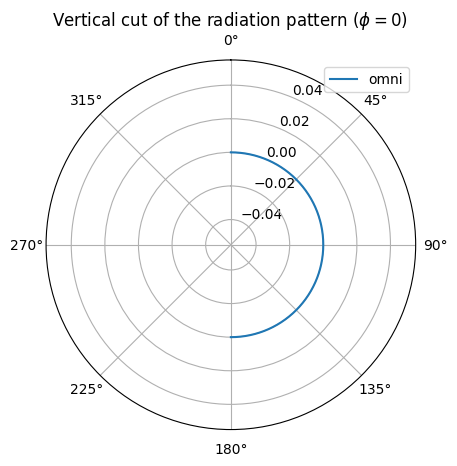

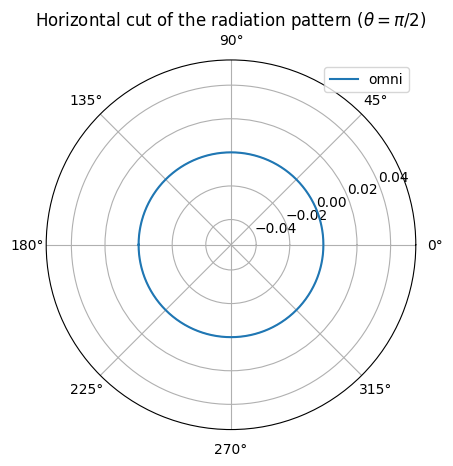

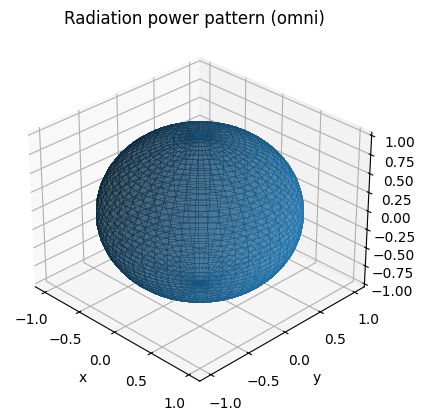

In [50]:
# 示例用法
antenna = AntennaElement(pattern="omni", slant_angle=0.9)
theta = tf.constant([0.1, 0.15, 0.9], dtype=tf.float32)
phi = tf.constant([0.4, 0.65, 0.9], dtype=tf.float32)
f_theta, f_phi = antenna.field(theta, phi)
print(f"Theta component: {f_theta}")
print(f"Phi component: {f_phi}")

# 显示天线元件的辐射模式
antenna.show()

# 计算天线的增益和方向性
gain_db, directivity_db = antenna._compute_gain()
print(f"Antenna Gain (dB): {gain_db}")
print(f"Antenna Directivity (dB): {directivity_db}")

tf.Tensor(
[[ 0.   -3.15  1.05]
 [ 0.   -3.15  0.75]
 [ 0.   -3.15  0.45]
 [ 0.   -3.15  0.15]
 [ 0.   -3.15 -0.15]
 [ 0.   -3.15 -0.45]
 [ 0.   -3.15 -0.75]
 [ 0.   -3.15 -1.05]
 [ 0.   -2.25  1.05]
 [ 0.   -2.25  0.75]
 [ 0.   -2.25  0.45]
 [ 0.   -2.25  0.15]
 [ 0.   -2.25 -0.15]
 [ 0.   -2.25 -0.45]
 [ 0.   -2.25 -0.75]
 [ 0.   -2.25 -1.05]
 [ 0.   -1.35  1.05]
 [ 0.   -1.35  0.75]
 [ 0.   -1.35  0.45]
 [ 0.   -1.35  0.15]
 [ 0.   -1.35 -0.15]
 [ 0.   -1.35 -0.45]
 [ 0.   -1.35 -0.75]
 [ 0.   -1.35 -1.05]
 [ 0.   -0.45  1.05]
 [ 0.   -0.45  0.75]
 [ 0.   -0.45  0.45]
 [ 0.   -0.45  0.15]
 [ 0.   -0.45 -0.15]
 [ 0.   -0.45 -0.45]
 [ 0.   -0.45 -0.75]
 [ 0.   -0.45 -1.05]
 [ 0.    0.45  1.05]
 [ 0.    0.45  0.75]
 [ 0.    0.45  0.45]
 [ 0.    0.45  0.15]
 [ 0.    0.45 -0.15]
 [ 0.    0.45 -0.45]
 [ 0.    0.45 -0.75]
 [ 0.    0.45 -1.05]
 [ 0.    1.35  1.05]
 [ 0.    1.35  0.75]
 [ 0.    1.35  0.45]
 [ 0.    1.35  0.15]
 [ 0.    1.35 -0.15]
 [ 0.    1.35 -0.45]
 [ 0.    1.35 -0.75]
 [

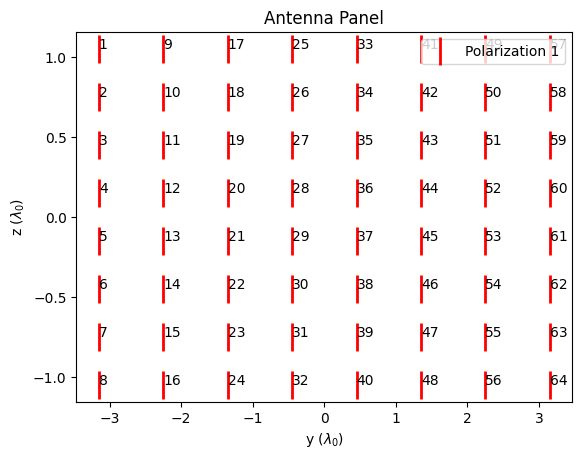

In [51]:
# 示例用法
antenna_panel = AntennaPanel(num_rows=8, num_cols=8, polarization="single", vertical_spacing=0.3, horizontal_spacing=0.9)
print(antenna_panel.ant_pos)
antenna_panel.show()
plt.show()

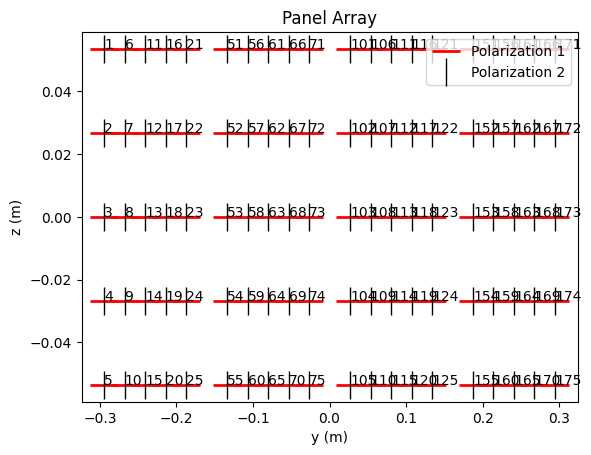

In [71]:
# 使用例子
array = PanelArray(num_rows_per_panel=5, num_cols_per_panel=5, polarization='dual', polarization_type='VH',
                   antenna_pattern='38.901', carrier_frequency=5.6e9, num_cols=4, panel_horizontal_spacing=3.0)
array.show()

## pytorch

In [74]:
"""3GPP TR 38.901 antenna modeling"""
import torch
from torch import sin, cos,sqrt,log10

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle

from my_code.mysionna.constants import SPEED_OF_LIGHT, PI
def torch_gather(input_data, indices, axis=None, batch_dims=0):
    shape_input = input_data.shape
    shape_index = indices.shape

    shape_new = np.array(shape_input)
    shape_new = np.delete(shape_new, axis)
    shape_new = np.insert(shape_input, axis, shape_index)

    data_new = torch.tensor(shape_new)
    
    for i in range(len(shape_index) - 1):
        cu_index =  len(shape_index) + axis - i - 1
        torch.index_select(input_data, axis, indices)
    else:
        out_data = torch.index_select(input_data, axis, indices)
    
    return out_data
class AntennaElement:
    """Antenna element following the [TR38901]_ specification

    Parameters
    ----------
    pattern : str
        Radiation pattern. Should be "omni" or "38.901".

    slant_angle : float
        Polarization slant angle [radian]

    dtype : torch.dtype
        Complex datatype to use for internal processing and output.
        Defaults to `torch.complex64`.
    """
    def __init__(self,
                 pattern,
                 slant_angle=0.0,
                 dtype=torch.complex64
                 ):
        
        assert pattern in ["omni", "38.901"],\
            "The radiation_pattern must be one of [\"omni\", \"38.901\"]."
        assert dtype.is_complex, "'dtype' must be complex type"

        if dtype == torch.complex32:
            real_dtype = torch.float16
        elif dtype == torch.complex64:
            real_dtype = torch.float32
        elif dtype == torch.complex128:
            real_dtype = torch.float64
        else:
            raise TypeError ("Not found comfortable type")
        
        self._pattern = pattern
        self._slant_angle = torch.tensor(slant_angle,dtype=real_dtype)

        # Selected the radiation field correspding to the requested pattern
        if pattern == "omni":
            self._radiation_pattern = self._radiation_pattern_omni
        else:
            self._radiation_pattern = self._radiation_pattern_38901

        self._dtype = dtype
    def field(self, theta, phi):
        """
        Field pattern in the vertical and horizontal polarization (7.3-4/5)

        Inputs
        -------
        theta:
            Zenith angle wrapped within (0,pi) [radian]

        phi:
            Azimuth angle wrapped within (-pi, pi) [radian]
        """
        a = sqrt(self._radiation_pattern(theta, phi))
        f_theta = a * cos(self._slant_angle)
        f_phi   = a * sin(self._slant_angle)
        return (f_theta, f_phi)
    def show(self):
        """
        Shows the field pattern of an antenna element
        """
        theta = torch.linspace(0.0, PI, 361)
        phi = torch.linspace(-PI, PI, 361)
        a_v = 10*log10(self._radiation_pattern(theta, torch.zeros_like(theta)))
        a_h = 10*log10(self._radiation_pattern(PI/2*torch.ones_like(phi) , phi))
        
        fig = plt.figure()
        plt.polar(theta, a_v)
        fig.axes[0].set_theta_zero_location("N")
        fig.axes[0].set_theta_direction(-1)
        plt.title(r"Vertical cut of the radiation pattern ($\phi = 0 $) ")
        plt.legend([f"{self._pattern}"])

        fig = plt.figure()
        plt.polar(phi, a_h)
        fig.axes[0].set_theta_zero_location("E")
        plt.title(r"Horizontal cut of the radiation pattern ($\theta = \pi/2$)")
        plt.legend([f"{self._pattern}"])

        theta = torch.linspace(0.0, PI, 50)
        phi = torch.linspace(-PI, PI, 50)
        phi_grid, theta_grid = torch.meshgrid(phi, theta)
        a = self._radiation_pattern(theta_grid, phi_grid)
        x = a * sin(theta_grid) * cos(phi_grid)
        y = a * sin(theta_grid) * sin(phi_grid)
        z = a * cos(theta_grid)
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(x.numpy(), y.numpy(), z.numpy(), rstride=1, cstride=1,
                        linewidth=0, antialiased=False, alpha=0.5)
        ax.view_init(elev=30., azim=-45)
        plt.xlabel("x")
        plt.ylabel("y")
        ax.set_zlabel("z")
        plt.title(f"Radiation power pattern ({self._pattern})")    

    ###############################
    # Utility functions
    ###############################

    def _radiation_pattern_omni(self, theta, phi):
        """
        Radiation pattern of an omnidirectional 3D radiation pattern

        Inputs
        -------
        theta:
            Zenith angle

        phi:
            Azimuth angle
        """
        return torch.ones_like(theta)

    def _radiation_pattern_38901(self, theta, phi):
        """
        Radiation pattern from TR38901 (Table 7.3-1)

        Inputs
        -------
        theta:
            Zenith angle wrapped within (0,pi) [radian]

        phi:
            Azimuth angle wrapped within (-pi, pi) [radian]
        """
        theta_3db = phi_3db = 65 / 180 * PI
        a_max = sla_v = 30
        g_e_max = 8
        a_v = -torch.minimum(12 * ((theta - PI / 2) / theta_3db) ** 2, torch.tensor(sla_v, dtype=torch.float32))
        a_h = -torch.minimum(12 * (phi / phi_3db) ** 2, torch.tensor(a_max, dtype=torch.float32))
        a_db = -torch.minimum(-(a_v + a_h), torch.tensor(a_max, dtype=torch.float32)) + g_e_max
        return 10 ** (a_db / 10)

    def _compute_gain(self):
        """
        Compute antenna gain and directivity through numerical integration
        """
        # Create angular meshgrid
        theta = torch.linspace(0.0, PI, 181)
        phi = torch.linspace(-PI, PI, 361)
        phi_grid, theta_grid = torch.meshgrid(phi, theta)

        # Compute field strength over the grid
        f_theta, f_phi = self.field(theta_grid, phi_grid)
        u = f_theta ** 2 + f_phi ** 2
        gain_db = 10 * log10(torch.max(u))

        # Numerical integration of the field components
        dtheta = theta[1] - theta[0]
        dphi = phi[1] - phi[0]
        po = torch.sum(u * sin(theta_grid) * dtheta * dphi)

        # Compute directivity
        u_bar = po / (4 * PI)  # Equivalent isotropic radiator
        d = u / u_bar  # Directivity grid
        directivity_db = 10 * log10(torch.max(d))
        return gain_db, directivity_db
class AntennaPanel:
    """Antenna panel following the [TR38901]_ specification

    Parameters
    -----------

    num_rows : int
        Number of rows forming the panel

    num_cols : int
        Number of columns forming the panel

    polarization : str
        Polarization. Should be "single" or "dual"

    vertical_spacing : float
        Vertical antenna element spacing [multiples of wavelength]

    horizontal_spacing : float
        Horizontal antenna element spacing [multiples of wavelength]

    dtype : tf.DType
        Complex datatype to use for internal processing and output.
        Defaults to `tf.complex64`.
    """
    def __init__(self,
                 num_rows,
                 num_cols,
                 polarization,
                 vertical_spacing,
                 horizontal_spacing,
                 dtype=torch.complex64):
        assert dtype.is_complex, "'dtype' must be complex type"
        assert polarization in ('single', 'dual'), \
            "polarization must be either 'single' or 'dual'"
        # set real_dtype
        if dtype == torch.complex32:
            real_dtype = torch.float16
        elif dtype == torch.complex64:
            real_dtype = torch.float32
        elif dtype == torch.complex128:
            real_dtype = torch.float64
        else:
            raise TypeError ("Not found comfortable type")
        
        self._num_rows = torch.tensor(num_rows, dtype=torch.int32)
        self._num_cols = torch.tensor(num_cols, dtype=torch.int32)
        self._polarization = polarization
        self._horizontal_spacing = torch.tensor(horizontal_spacing, 
                                                dtype=real_dtype)
        self._vertical_spacing = torch.tensor(vertical_spacing, 
                                              dtype=real_dtype)
        self._dtype = real_dtype

        # Place the antenna elements of the first polarization direction
        # on the y-z-plane
        p = 1 if polarization == 'single' else 2
        ant_pos = np.zeros([num_rows*num_cols*p, 3])
        for i in range(num_rows):
            for j in range(num_cols):
                ant_pos[i +j*num_rows] = [  0,
                                            j*horizontal_spacing,
                                            -i*vertical_spacing]
        
        # Center the panel around the origin
        offset = [  0,
                    -(num_cols-1)*horizontal_spacing/2,
                    (num_rows-1)*vertical_spacing/2]
        ant_pos += offset

        # Create the antenna elements of the second polarization direction
        if polarization == 'dual':
            ant_pos[num_rows*num_cols:] = ant_pos[:num_rows*num_cols]
        self._ant_pos = torch.tensor(ant_pos, dtype=real_dtype)
        
    @property
    def ant_pos(self):
        """Antenna positions in the local coordinate system"""
        return self._ant_pos

    @property
    def num_rows(self):
        """Number of rows"""
        return self._num_rows

    @property
    def num_cols(self):
        """Number of columns"""
        return self._num_cols

    @property
    def polarization(self):
        """Polarization ("single" or "dual")"""
        return self._polarization

    @property
    def vertical_spacing(self):
        """Vertical spacing between elements [multiple of wavelength]"""
        return self._vertical_spacing

    @property
    def horizontal_spacing(self):
        """Horizontal spacing between elements [multiple of wavelength]"""
        return self._horizontal_spacing

    def show(self):
        """Shows the panel geometry"""
        fig = plt.figure()
        pos = self._ant_pos[:self._num_rows*self._num_cols]
        plt.plot(pos[:, 1].numpy(), pos[:, 2].numpy(), marker="|", markeredgecolor='red',
                 markersize="20", linestyle="None", markeredgewidth="2")
        for i, p in enumerate(pos):
            fig.axes[0].annotate(i + 1, (p[1], p[2]))
        if self._polarization == 'dual':
            pos = self._ant_pos[self._num_rows*self._num_cols:]
            plt.plot(pos[:, 1].numpy(), pos[:, 2].numpy(), marker="_", markeredgecolor='black',
                     markersize="20", linestyle="None", markeredgewidth="1")
        plt.xlabel(r"y ($\lambda_0$)")
        plt.ylabel(r"z ($\lambda_0$)")
        plt.title("Antenna Panel")
        plt.legend(["Polarization 1", "Polarization 2"], loc="upper right")        
class PanelArray:
    def __init__(self,  num_rows_per_panel,
                        num_cols_per_panel,
                        polarization,
                        polarization_type,
                        antenna_pattern,
                        carrier_frequency,
                        num_rows=1,
                        num_cols=1,
                        panel_vertical_spacing=None,
                        panel_horizontal_spacing=None,
                        element_vertical_spacing=None,
                        element_horizontal_spacing=None,
                        dtype=torch.complex64):
        
        if dtype == torch.complex32:
            real_dtype = torch.float16
        elif dtype == torch.complex64:
            real_dtype = torch.float32
        elif dtype == torch.complex128:
            real_dtype = torch.float64
        else:
            raise TypeError ("Not found comfortable type")
    
        assert dtype.is_complex, "'dtype' must be complex type"

        assert polarization in ('single', 'dual'), \
            "polarization must be either 'single' or 'dual'"
        
        # Setting default values for antenna and panel spacings if not
        # specified by the user
        # Default spacing for antenna elements is half a wavelength
        if element_vertical_spacing is None:
            element_vertical_spacing = 0.5
        if element_horizontal_spacing is None:
            element_horizontal_spacing = 0.5
        # Default values of panel spacing is the pannel size + 0.5
        if panel_vertical_spacing is None:
            panel_vertical_spacing = (num_rows_per_panel-1)\
                *element_vertical_spacing+0.5
        if panel_horizontal_spacing is None:
            panel_horizontal_spacing = (num_cols_per_panel-1)\
                *element_horizontal_spacing+0.5

        # Check that panel spacing is larger than panel dimensions
        assert panel_horizontal_spacing > (num_cols_per_panel-1)\
            *element_horizontal_spacing,\
                "Pannel horizontal spacing must be larger than the panel width"
        assert panel_vertical_spacing > (num_rows_per_panel-1)\
            *element_vertical_spacing,\
            "Pannel vertical spacing must be larger than panel height"
        
        self._num_rows = torch.tensor(num_rows, dtype=torch.int32)
        self._num_cols = torch.tensor(num_cols, dtype=torch.int32)
        self._num_rows_per_panel = torch.tensor(num_rows_per_panel, dtype=torch.int32)
        self._num_cols_per_panel = torch.tensor(num_cols_per_panel, dtype=torch.int32)
        self._polarization = polarization
        self._polarization_type = polarization_type
        self._panel_vertical_spacing = torch.tensor(panel_vertical_spacing, 
                                                    dtype=real_dtype)
        self._panel_horizontal_spacing = torch.tensor(panel_horizontal_spacing, 
                                                      dtype=real_dtype)
        self._element_vertical_spacing = torch.tensor(element_vertical_spacing, 
                                                      dtype=real_dtype)
        self._element_horizontal_spacing = torch.tensor(element_horizontal_spacing, 
                                                        dtype=real_dtype)
        self._dtype = dtype

        self._num_panels = torch.tensor(num_cols*num_rows, dtype=torch.int32)
        
        p = 1 if polarization == 'single' else 2
        self._num_panel_ant = torch.tensor( num_cols_per_panel*
                                            num_rows_per_panel*p,
                                            dtype=torch.int32)
        
        # Total number of antenna elements
        self._num_ant = self._num_panels * self._num_panel_ant
        
        # Wavelength (m)
        self._lambda_0 = torch.tensor(SPEED_OF_LIGHT / carrier_frequency,
                                      dtype= real_dtype)
        
        # Create one antenna element for each polarization direction
        # polarization must be one of {"V", "H", "VH", "cross"}
        if polarization == 'single':
            assert polarization_type in ["V", "H"],\
                "For single polarization, polarization_type must be 'V' or 'H'"
            slant_angle = 0 if polarization_type == "V" else PI/2
            self._ant_pol1 = AntennaElement(antenna_pattern, slant_angle,
                self._dtype)
        else:
            assert polarization_type in ["VH", "cross"],\
            "For dual polarization, polarization_type must be 'VH' or 'cross'"
            slant_angle = 0 if polarization_type == "VH" else -PI/4
            self._ant_pol1 = AntennaElement(antenna_pattern, slant_angle,
                self._dtype)
            self._ant_pol2 = AntennaElement(antenna_pattern, slant_angle+PI/2,
                self._dtype)
            
        # Compose array from panels
        ant_pos = np.zeros([self._num_ant, 3])
        panel = AntennaPanel(num_rows_per_panel, num_cols_per_panel,
            polarization, element_vertical_spacing, element_horizontal_spacing,
            dtype)
        pos = panel.ant_pos.numpy()
        count = 0
        num_panel_ant = self._num_panel_ant
        for j in range(num_cols):
            for i in range(num_rows):
                offset = [  0,
                            j*panel_horizontal_spacing,
                            -i*panel_vertical_spacing]
                new_pos = pos + offset
                ant_pos[count*num_panel_ant:(count+1)*num_panel_ant] = new_pos
                count += 1
        # Center the entire panel array around the orgin of the y-z plane
        offset = [  0,
                    -(num_cols-1)*panel_horizontal_spacing/2,
                    (num_rows-1)*panel_vertical_spacing/2]
        ant_pos += offset
        # Scale antenna element positions by the wavelength
        ant_pos *= self._lambda_0.numpy()
        self._ant_pos = torch.tensor(ant_pos, dtype=real_dtype)

        # Compute indices of antennas for polarization directions
        ind = np.arange(0, self._num_ant)
        ind = np.reshape(ind, [self._num_panels*p, -1])
        self._ant_ind_pol1 = torch.tensor(np.reshape(ind[::p], [-1]), dtype=torch.int32)
        if polarization == 'single':
            self._ant_ind_pol2 = torch.tensor(np.array([]), dtype=torch.int32)
        else:
            self._ant_ind_pol2 = torch.tensor(np.reshape(
                ind[1:self._num_panels*p:2], [-1]), dtype=torch.int32)
            
        # Get positions of antenna elements for each polarization direction
        self._ant_pos_pol1 = torch_gather(self._ant_pos, self._ant_ind_pol1,
                                        axis=0)
        self._ant_pos_pol2 = torch_gather(self._ant_pos, self._ant_ind_pol2,
                                        axis=0)
        
    @property
    def num_rows(self):
        """Number of rows of panels"""
        return self._num_rows

    @property
    def num_cols(self):
        """Number of columns of panels"""
        return self._num_cols

    @property
    def num_rows_per_panel(self):
        """Number of rows of elements per panel"""
        return self._num_rows_per_panel

    @property
    def num_cols_per_panel(self):
        """Number of columns of elements per panel"""
        return self._num_cols_per_panel

    @property
    def polarization(self):
        """Polarization ("single" or "dual")"""
        return self._polarization

    @property
    def polarization_type(self):
        """Polarization type. "V" or "H" for single polarization.
        "VH" or "cross" for dual polarization."""
        return self._polarization_type

    @property
    def panel_vertical_spacing(self):
        """Vertical spacing between the panels [multiple of wavelength]"""
        return self._panel_vertical_spacing

    @property
    def panel_horizontal_spacing(self):
        """Horizontal spacing between the panels [multiple of wavelength]"""
        return self._panel_horizontal_spacing

    @property
    def element_vertical_spacing(self):
        """Vertical spacing between the antenna elements within a panel
        [multiple of wavelength]"""
        return self._element_vertical_spacing

    @property
    def element_horizontal_spacing(self):
        """Horizontal spacing between the antenna elements within a panel
        [multiple of wavelength]"""
        return self._element_horizontal_spacing

    @property
    def num_panels(self):
        """Number of panels"""
        return self._num_panels

    @property
    def num_panels_ant(self):
        """Number of antenna elements per panel"""
        return self._num_panel_ant

    @property
    def num_ant(self):
        """Total number of antenna elements"""
        return self._num_ant

    @property
    def ant_pol1(self):
        """Field of an antenna element with the first polarization direction"""
        return self._ant_pol1

    @property
    def ant_pol2(self):
        """Field of an antenna element with the second polarization direction.
        Only defined with dual polarization."""
        assert self._polarization == 'dual',\
            "This property is not defined with single polarization"
        return self._ant_pol2

    @property
    def ant_pos(self):
        """Positions of the antennas"""
        return self._ant_pos

    @property
    def ant_ind_pol1(self):
        """Indices of antenna elements with the first polarization direction"""
        return self._ant_ind_pol1

    @property
    def ant_ind_pol2(self):
        """Indices of antenna elements with the second polarization direction.
        Only defined with dual polarization."""
        assert self._polarization == 'dual',\
            "This property is not defined with single polarization"
        return self._ant_ind_pol2

    @property
    def ant_pos_pol1(self):
        """Positions of the antenna elements with the first polarization
        direction"""
        return self._ant_pos_pol1

    @property
    def ant_pos_pol2(self):
        """Positions of antenna elements with the second polarization direction.
        Only defined with dual polarization."""
        assert self._polarization == 'dual',\
            "This property is not defined with single polarization"
        return self._ant_pos_pol2
    
    def show(self):
        """Show the panel array geometry"""
        if self._polarization == 'single':
            if self._polarization_type == 'H':
                marker_p1 = MarkerStyle("_").get_marker()
            else:
                marker_p1 = MarkerStyle("|")
        elif self._polarization == 'dual':
            if self._polarization_type == 'cross':
                marker_p1 = (2, 0, -45)
                marker_p2 = (2, 0, 45)
            else:
                marker_p1 = MarkerStyle("_").get_marker()
                marker_p2 = MarkerStyle("|").get_marker()

        fig = plt.figure()
        pos_pol1 = self._ant_pos_pol1
        plt.plot(pos_pol1[:,1], pos_pol1[:,2],
            marker=marker_p1, markeredgecolor='red',
            markersize="20", linestyle="None", markeredgewidth="2")
        for i, p in enumerate(pos_pol1):
            fig.axes[0].annotate(self._ant_ind_pol1[i].numpy()+1, (p[1], p[2]))
        if self._polarization == 'dual':
            pos_pol2 = self._ant_pos_pol2
            plt.plot(pos_pol2[:,1], pos_pol2[:,2],
                marker=marker_p2, markeredgecolor='black',
                markersize="20", linestyle="None", markeredgewidth="1")
        plt.xlabel("y (m)")
        plt.ylabel("z (m)")
        plt.title("Panel Array")
        plt.legend(["Polarization 1", "Polarization 2"], loc="upper right")

    def show_element_radiation_pattern(self):
        """Show the radiation field of antenna elements forming the panel"""
        self._ant_pol1.show()




Theta component: tensor([0.6216, 0.6216, 0.6216])
Phi component: tensor([0.7833, 0.7833, 0.7833])
Antenna Gain (dB): -2.588596998975845e-07
Antenna Directivity (dB): -0.011911699548363686


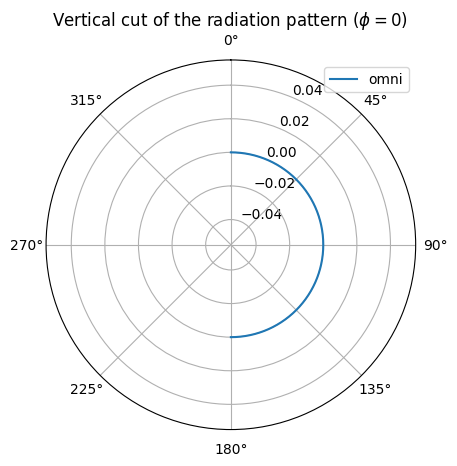

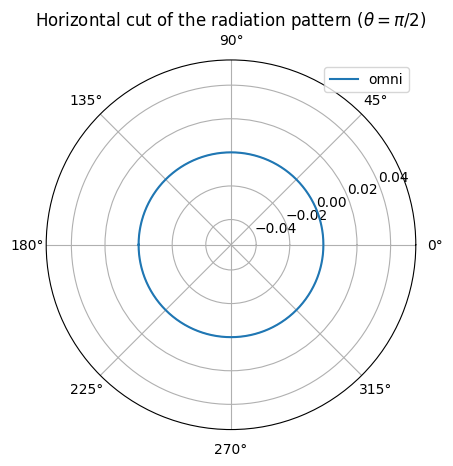

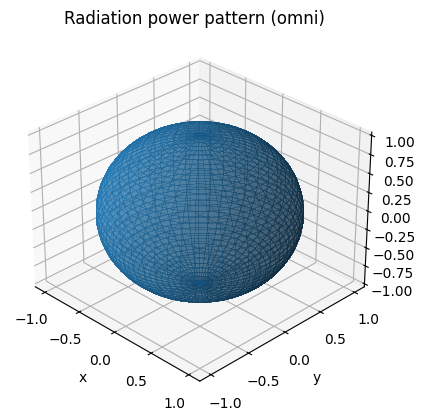

In [30]:
# 示例用法
antenna = AntennaElement(pattern="omni", slant_angle=0.9)
theta = torch.tensor([0.1, 0.15, 0.9], dtype=torch.float32)
phi = torch.tensor([0.4, 0.65, 0.9], dtype=torch.float32)
f_theta, f_phi = antenna.field(theta, phi)
print(f"Theta component: {f_theta}")
print(f"Phi component: {f_phi}")

# 显示天线元件的辐射模式
antenna.show()

# 计算天线的增益和方向性
gain_db, directivity_db = antenna._compute_gain()
print(f"Antenna Gain (dB): {gain_db}")
print(f"Antenna Directivity (dB): {directivity_db}")

tensor([[ 0.0000, -3.1500,  1.0500],
        [ 0.0000, -3.1500,  0.7500],
        [ 0.0000, -3.1500,  0.4500],
        [ 0.0000, -3.1500,  0.1500],
        [ 0.0000, -3.1500, -0.1500],
        [ 0.0000, -3.1500, -0.4500],
        [ 0.0000, -3.1500, -0.7500],
        [ 0.0000, -3.1500, -1.0500],
        [ 0.0000, -2.2500,  1.0500],
        [ 0.0000, -2.2500,  0.7500],
        [ 0.0000, -2.2500,  0.4500],
        [ 0.0000, -2.2500,  0.1500],
        [ 0.0000, -2.2500, -0.1500],
        [ 0.0000, -2.2500, -0.4500],
        [ 0.0000, -2.2500, -0.7500],
        [ 0.0000, -2.2500, -1.0500],
        [ 0.0000, -1.3500,  1.0500],
        [ 0.0000, -1.3500,  0.7500],
        [ 0.0000, -1.3500,  0.4500],
        [ 0.0000, -1.3500,  0.1500],
        [ 0.0000, -1.3500, -0.1500],
        [ 0.0000, -1.3500, -0.4500],
        [ 0.0000, -1.3500, -0.7500],
        [ 0.0000, -1.3500, -1.0500],
        [ 0.0000, -0.4500,  1.0500],
        [ 0.0000, -0.4500,  0.7500],
        [ 0.0000, -0.4500,  0.4500],
 

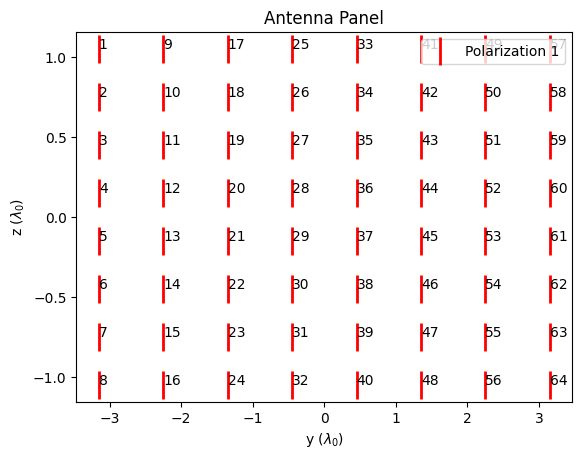

In [48]:
# 示例用法
antenna_panel = AntennaPanel(num_rows=8, num_cols=8, polarization="single", vertical_spacing=0.3, horizontal_spacing=0.9)
print(antenna_panel.ant_pos)
antenna_panel.show()
plt.show()

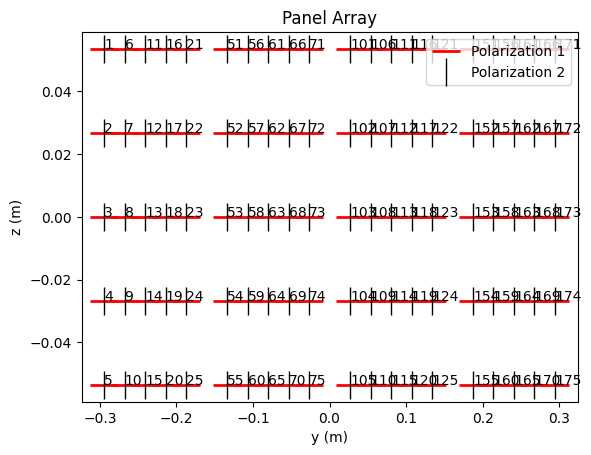

In [77]:
# 使用例子
array = PanelArray(num_rows_per_panel=5, num_cols_per_panel=5, polarization='dual', polarization_type='VH',
                   antenna_pattern='38.901', carrier_frequency=5.6e9, num_cols=4, panel_horizontal_spacing=3.0)
array.show()